# Mean reversion 

Pairs trade is a mean-reverting strategy, betting that the prices will eventually revert to their historical trends.
🔧 Étape 1 – Ce que tu vas construire

Composant	Description

📥 Données	Téléchargement des prix de 2 actifs historiquement corrélés (ex : Coca-Cola et Pepsi, ou EUR/USD et GBP/USD)

📈 Spread	Calcul du spread entre les deux séries de prix

🔍 Détection de signal	Quand le spread s’écarte de la moyenne d’un certain seuil (Z-score), on parie sur un retour

🤖 Backtest	Simuler les entrées/sorties et calculer le PnL

⚙️ C++	Optimisation du calcul du Z-score, indicateurs et backtest

📊 Python	Gestion des données, visualisation, entraînement éventuel d’un modèle pour anticiper le retour à la moyenne

🔜 Prochaine étape :
On récupère des données de deux actifs corrélés.

Tu préfères :

Actions (ex : KO & PEP)

Forex (ex : EUR/USD & GBP/USD)

Crypto (ex : BTC & ETH)

Dis-moi et je t’indique comment récupérer les données et préparer le projet proprement.

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pandas as pd

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'AMZN', 'META', 'JPM', 'XOM', 'UNH']

In [3]:
start_date = "2020-04-01"
end_date = "2025-03-31"
data = yf.download(tickers, start=start_date, end=end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


I start here by selecting only the close price data in order to check if there is any correlation between two stock prices that I could use for the strategy.

In [4]:
correlated_data = data['Close']

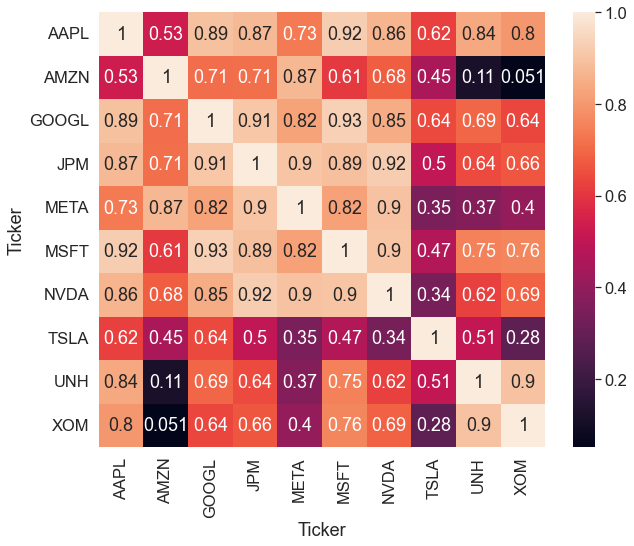

In [5]:
correlated_data.corr()
plt.figure(figsize= (10,8))
sns.set(font_scale=1.5)
sns.heatmap(correlated_data.corr(), annot=True)
plt.show()

We can observe that the maximum correlation ratio is between Microsoft and Google so we'll take this pair as a test. 

In [6]:
selected_data = data.loc[:, (slice(None), ['GOOGL', 'MSFT'])]

selected_data.head()

Price           Close                   High                    Low  \
Ticker          GOOGL        MSFT      GOOGL        MSFT      GOOGL   
Date                                                                  
2020-04-01  54.842796  145.596481  56.202298  150.994970  54.414345   
2020-04-02  55.585751  148.611572  55.871384  148.822153  54.396437   
2020-04-03  54.375034  147.242798  55.673328  150.640785  53.498230   
2020-04-06  58.878006  158.192947  59.254206  159.370273  55.982350   
2020-04-07  58.846657  156.489166  60.748567  162.720395  58.582421   

Price                        Open                Volume            
Ticker            MSFT      GOOGL        MSFT     GOOGL      MSFT  
Date                                                               
2020-04-01  144.361727  55.932587  146.448370  51970000  57969900  
2020-04-02  143.921402  54.738301  145.357170  56410000  49630700  
2020-04-03  145.673025  55.470300  148.458419  51374000  41243300  
2020-04-06  150.832240  56.380448  153.454915  63320000  67111700  
2020-04-07  156.269005  60.560961  162.327948  61620000  62769000

I'm going to use a simple linear regression to find the hedge called here Beta :

In [7]:
price_1 = selected_data['Close','GOOGL']

price_2 = selected_data['Close','MSFT']

In [8]:
# Reshape prix_B pour qu'il soit en 2D (n_samples, 1)
X = price_2.to_numpy().reshape(-1, 1)
y = price_1.to_numpy()

# Fit le modèle
model = LinearRegression(fit_intercept=False)  # pas d'ordonnée à l'origine
model.fit(X, y)

# Hedge ratio β
beta = model.coef_[0]
print(f"Hedge ratio β = {beta:.4f}")

Hedge ratio β = 0.4107


With the hedge Beta we can find the spread.

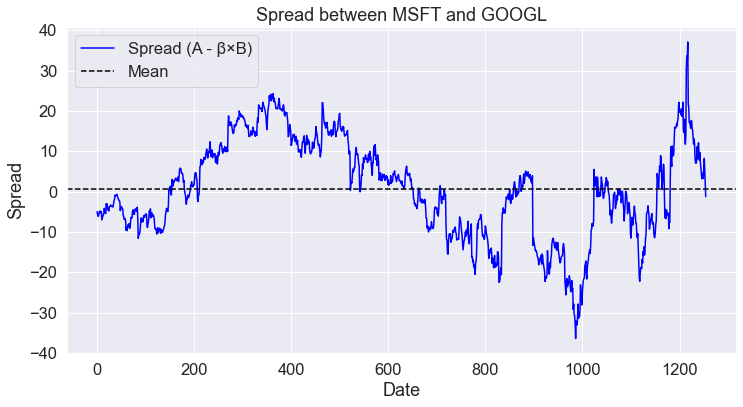

In [9]:
spread = y - beta * X.flatten()  # y = price_1, X = price_2.reshape(-1,1)

plt.figure(figsize=(12, 6))
plt.plot(spread, label='Spread (A - β×B)', color='blue')
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.title('Spread between MSFT and GOOGL')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
std_spread = np.std(spread)
print(f"The std of the spread is : {std_spread:.4f}")

The std of the spread is : 12.1098


Now that we got the spread it's time for the backtesting. 

In [66]:
# Parameters
spread = np.array(spread)
price_1 = np.array(price_1)
price_2 = np.array(price_2)
initial_balance = 10000 
position_size = 1      
spread_mean = spread.mean()  
std_spread = np.std(spread)  
threshold =  2*std_spread

balance = initial_balance
positions = 0  # Position opened or closed (0 = No position taken, 1 = long actif 1/short actif 2, -1 = short actif 1/long actif 2)
trade_log = []
performance = [initial_balance]
transaction_cost = 0.001  
entry_price_1 = 0
entry_price_2 = 0

In [67]:
# Backtesting
for i in range(1, len(spread)):
    # Spread > 2σ (position short)
    if spread[i] > spread_mean + threshold and positions != -1:
        if positions != 0:
            
            profit = positions * (price_1[i] - entry_price_1) + positions * (entry_price_2 - price_2[i])
            balance += profit
            balance -= abs(positions) * (price_1[i] + price_2[i]) * transaction_cost  # Coût de transaction
            trade_log.append(f"Fermeture de position à {price_1[i]} et {price_2[i]}, Bénéfice : {profit:.2f}")
        positions = -1  
        entry_price_1 = price_1[i]
        entry_price_2 = price_2[i]
        balance -= (price_1[i] + price_2[i]) * transaction_cost 
        trade_log.append(f"Short actif 1, Long actif 2 à {price_1[i]} et {price_2[i]}")

    #  Spread < -2σ (position long)
    elif spread[i] < spread_mean - threshold and positions != 1:
        if positions != 0:
        
            profit = positions * (price_1[i] - entry_price_1) + positions * (entry_price_2 - price_2[i])
            balance += profit
            balance -= abs(positions) * (price_1[i] + price_2[i]) * transaction_cost 
            trade_log.append(f"Fermeture de position à {price_1[i]} et {price_2[i]}, Bénéfice : {profit:.2f}")
        positions = 1  
        entry_price_1 = price_1[i]
        entry_price_2 = price_2[i]
        balance -= (price_1[i] + price_2[i]) * transaction_cost  
        trade_log.append(f"Long actif 1, Short actif 2 à {price_1[i]} et {price_2[i]}")

    #  out :
    elif abs(spread[i] - spread_mean) < threshold and positions != 0:
        profit = positions * (price_1[i] - entry_price_1) + positions * (entry_price_2 - price_2[i])
        balance += profit
        balance -= abs(positions) * (price_1[i] + price_2[i]) * transaction_cost  # Coût de transaction
        positions = 0  
        trade_log.append(f"Fermeture de position à {price_1[i]} et {price_2[i]}, Bénéfice : {profit:.2f}")

    performance.append(balance)



In [70]:
# Results
print(f"Final balance : {balance:.2f}")
print(f"Number of trades : {len(trade_log)}")
print("Trade log :")
for trade in trade_log:
    print(trade)

Final balance : 10006.27
Number of trades : 10
Trade log :
Long actif 1, Short actif 2 à 140.48834228515625 et 399.98101806640625
Fermeture de position à 142.99632263183594 et 401.8333435058594, Bénéfice : 0.66
Long actif 1, Short actif 2 à 139.85137939453125 et 400.99847412109375
Fermeture de position à 141.8717041015625 et 399.13275146484375, Bénéfice : 3.89
Long actif 1, Short actif 2 à 143.40438842773438 et 408.531005859375
Fermeture de position à 146.977294921875 et 414.1580505371094, Bénéfice : -2.05
Long actif 1, Short actif 2 à 146.33041381835938 et 418.21710205078125
Fermeture de position à 149.35594177246094 et 419.65606689453125, Bénéfice : 1.59
Short actif 1, Long actif 2 à 200.638916015625 et 414.1595458984375
Fermeture de position à 191.1099090576172 et 412.4629821777344, Bénéfice : 7.83


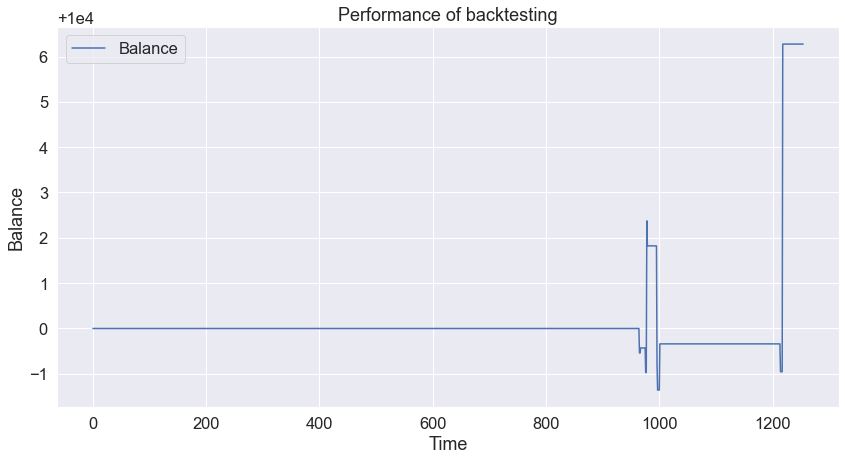

In [72]:
plt.figure(figsize=(14, 7))
plt.plot(performance, label='Balance')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.title('Performance of backtesting')
plt.legend()
plt.show()

Apparently, it seems that the threshold is too high to have lots of transactions because in 5 years there only are 10 transactions. So we have to find another way to create a pair, even so we had a positiv balance in the end. Moreover we can see that the pair is correlated in the same way and I think that's not good for us in the strategy.